# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
plt.style.use('seaborn')
%matplotlib inline

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [3]:
def load_data(data_dir='data/raw/physionet.org/files/wearable-exam-stress/1.0.0/data'): 
    """Load and organize the physiological data from the dataset.
    
    Parameters
    ----------
    data_dir : str
        Path to the directory containing the dataset files
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the organized physiological data with columns:
        ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """
    data = []

    for student in os.listdir(data_dir):
        if student.startswith("S"):

            for folder in ['Final', 'midterm_1', 'midterm_2']:

                    try:
                    
                        path = os.path.join(data_dir, student, folder)

                        #new function so I can open each file and filter out first 2 values (start time and rate)
                        #so I can then calcualte timepoints from them for the rest of the values
                        def load_file(file_name, col_name):
                            file_path = os.path.join(path, file_name)

                            with open(file_path, 'r') as f:
                                lines = f.readlines()

                            start_time = float(lines[0].strip())
                            sample_rate = float(lines[1].strip())

                            values = [float(line.strip()) for line in lines[2:]]
                            timestamps = [start_time + i / sample_rate for i in range(len(values))]

                            return pd.DataFrame({'timestamp': timestamps, col_name: values})

                        hr_df = load_file('HR.csv', 'heart_rate')
                        eda_df = load_file('EDA.csv', 'eda')
                        temp_df = load_file('TEMP.csv', 'temperature')

                        # Merge on timestamp
                        df = hr_df.merge(eda_df, on='timestamp').merge(temp_df, on='timestamp')
                        df['subject_id'] = student
                        df['session'] = folder

                        data.append(df)


                    except Exception as e:
                        print(f"Error loading {student} {folder}: {e}") #um don't crash plz

    return pd.concat(data)


phys_data = load_data()

## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [8]:
from scipy.stats import zscore

def preprocess_data(data, output_dir='data/processed'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Handle missing values
    # 2. Resample to regular intervals
    # 3. Remove outliers (z-score > 3)
    # 4. Save processed data to CSV files

    processed_data = []

    for subject_id in data['subject_id'].unique():
        try:
            subject_df = data[data['subject_id'] == subject_id].copy()

            # Ensure timestamp is datetime and index it
            subject_df['timestamp'] = pd.to_datetime(subject_df['timestamp'], unit='s')
            subject_df.set_index('timestamp', inplace=True)

            if 'session' not in subject_df.columns:
                print(f"No session column for {subject_id}, skipping...")
                continue

            # Split out metadata
            metadata_cols = ['subject_id', 'session']
            numeric_cols = subject_df.select_dtypes(include=[np.number]).columns

            # Group by session, resample, and interpolate numeric data
            resampled = (
                subject_df[numeric_cols]
                .groupby(subject_df['session'])
                .resample('1s')
                .mean()
                .interpolate(method='linear')
                .reset_index()
            )

            # Check missing data
            if resampled.isna().mean().max() > 0.01:
                print(f"Too many missing values for {subject_id}, skipping...")
                continue

            # Fill small remaining gaps
            resampled.ffill(inplace=True)
            resampled.bfill(inplace=True)

            # Remove outliers
            for col in ['heart_rate', 'eda', 'temperature']:
                if col in resampled.columns:
                    z = zscore(resampled[col].fillna(0))
                    resampled = resampled[np.abs(z) <= 3.5]

            # Restore metadata
            resampled['subject_id'] = subject_id
            resampled['session'] = resampled['session'].ffill()  # or use mode per group if needed

            processed_data.append(resampled)

            # Save
            output_path = os.path.join(output_dir, f'{subject_id}_processed.csv')
            resampled.to_csv(output_path, index=False)

        except Exception as e:
            print(f"Error processing {subject_id}: {e}")
            continue

    if processed_data:
        return pd.concat(processed_data, ignore_index=True)
    else:
        print("No valid subjects processed.")
        return pd.DataFrame()
    

clean_data = preprocess_data(data=phys_data)
    

## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

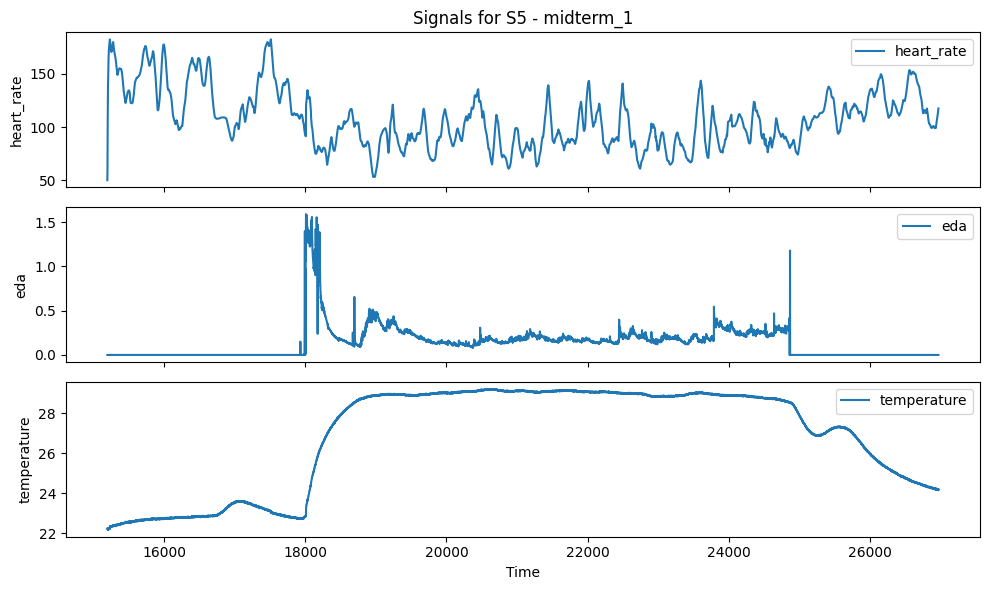

In [12]:
def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Create figure with subplots
    # 2. Plot each physiological signal
    # 3. Add labels and titles
    # 4. Save plot to file
    
    # Filter data for the given subject and session
    subset = data[(data['subject_id'] == subject_id) & (data['session'] == session)].copy()
    subset = subset.sort_index()  # Ensure time order if indexed by timestamp

    # Define signals to plot
    signals = ['heart_rate', 'eda', 'temperature']
    
    # Create subplots
    fig, axes = plt.subplots(len(signals), 1, figsize=(10, 6), sharex=True)
    
    for i, signal in enumerate(signals):
        if signal in subset.columns:
            axes[i].plot(subset.index, subset[signal], label=signal, color='tab:blue')
            axes[i].set_ylabel(signal)
            axes[i].legend(loc='upper right')
        else:
            axes[i].set_visible(False)

    axes[0].set_title(f'Signals for {subject_id} - {session}')
    axes[-1].set_xlabel('Time')

    # Save the figure
    filename = f"{subject_id}_{session.replace(' ', '_')}_signals.png"
    filepath = os.path.join(output_dir, filename)
    fig.tight_layout()
    fig.savefig(filepath)
    plt.close(fig)

    return fig


plot_physiological_signals(data=clean_data, subject_id='S5', session='midterm_1')